In [41]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import hp
from hyperopt import fmin, tpe, Trials, STATUS_OK

In [42]:
project_dir = '/Users/aidanbeilke/Desktop'

hyannis_folder = os.listdir(f"{project_dir}/Postgame_pdfs/csvs")
print(hyannis_folder)


['.Rhistory', 'combined_data2.csv', '.DS_Store', 'ml_ready.csv', 'hyannis.csv', 'check_leaders.csv', 'TM_2024_reg_szn (1).csv', '.RData', 'combined_data.csv']


In [43]:
df = None

for file in hyannis_folder:
    if file == 'ml_ready.csv':
        df = pd.read_csv(f"{project_dir}/Postgame_pdfs/csvs/ml_ready.csv", low_memory = False)
        
        

## EDA

In [44]:
df.shape

(1462896, 169)

In [45]:
df['PitchCall'].unique()

array(['StrikeCalled', 'StrikeSwinging', 'BallCalled', 'InPlay',
       'FoulBall', 'BallinDirt', 'HitByPitch', 'BallIntentional',
       'FoulBallFieldable', 'FoulBallNotFieldable',
       'FouldBallNotFieldable', 'Undefined', 'StrkeSwinging',
       'BattersInterference', 'StriekC'], dtype=object)

In [46]:
df['PlayResult'].unique()

array(['Undefined', 'Out', 'Single', 'FieldersChoice', 'Triple', 'Double',
       'Sacrifice', 'HomeRun', 'Error', 'StolenBase', 'CaughtStealing',
       'error', 'SIngle', 'homerun'], dtype=object)

In [47]:
[c for c in df.columns]

['PitchNo',
 'Date',
 'Time',
 'PAofInning',
 'PitchofPA',
 'Pitcher',
 'PitcherId',
 'PitcherThrows',
 'PitcherTeam',
 'Batter',
 'BatterId',
 'BatterSide',
 'BatterTeam',
 'PitcherSet',
 'Inning',
 'Top.Bottom',
 'Outs',
 'Balls',
 'Strikes',
 'TaggedPitchType',
 'AutoPitchType',
 'PitchCall',
 'KorBB',
 'TaggedHitType',
 'PlayResult',
 'OutsOnPlay',
 'RunsScored',
 'Notes',
 'RelSpeed',
 'VertRelAngle',
 'HorzRelAngle',
 'SpinRate',
 'SpinAxis',
 'Tilt',
 'RelHeight',
 'RelSide',
 'Extension',
 'VertBreak',
 'InducedVertBreak',
 'HorzBreak',
 'PlateLocHeight',
 'PlateLocSide',
 'ZoneSpeed',
 'VertApprAngle',
 'HorzApprAngle',
 'ZoneTime',
 'ExitSpeed',
 'Angle',
 'Direction',
 'HitSpinRate',
 'PositionAt110X',
 'PositionAt110Y',
 'PositionAt110Z',
 'Distance',
 'LastTrackedDistance',
 'Bearing',
 'HangTime',
 'pfxx',
 'pfxz',
 'x0',
 'y0',
 'z0',
 'vx0',
 'vy0',
 'vz0',
 'ax0',
 'ay0',
 'az0',
 'HomeTeam',
 'AwayTeam',
 'Stadium',
 'Level',
 'League',
 'GameID',
 'PitchUID',
 'Effec

In [48]:
cols = ['Date', 'Pitcher', 'PitcherId', 'PitcherTeam', 'Batter', 'BatterId', 'Outs', 'Balls',
        'Strikes', 'TaggedPitchType', 'AutoPitchType', 'PitchCall','PlayResult' ,'RelSpeed',
        'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'Tilt', 'RelHeight',
        'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide',
        'VertApprAngle', 'HorzApprAngle', 'BatterSide', 'PitcherThrows', 'pitch_type', 'ax0', 'ay0', 'az0', 
       'TaggedHitType']

data = df[cols]

In [49]:
## Pitch Type Classification

def classify_pitch_type(pitch_type):
    if isinstance(pitch_type, str):
        pitch_type = pitch_type.title()
    if pitch_type in ['Four-Seam', 'Fourseamfastball']:
        return 'Four-Seam'
    elif pitch_type in ['Twoseamfastball']:
        return 'Sinker'
    elif pitch_type in ['Changeup']:
        return 'ChangeUp'  
    else:
        return pitch_type

data['pitch_type'] = data['pitch_type'].apply(classify_pitch_type)


rm_pitch = ['Undefined', 'Other', 'Knuckleball', 'Oneseamfastball']
data = data[~data['pitch_type'].isin(rm_pitch)].copy()

/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_66954/3523544463.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pitch_type'] = data['pitch_type'].apply(classify_pitch_type)


## Get Pitcher's Primary Pitch

In [50]:
df_filtered = data[data['pitch_type'].isin(['Four-Seam', 'Sinker', 'Cutter'])].copy()

def primary_fastball(group):

    counts = group.value_counts()
    
    primary_pitch = counts.idxmax()
    
    return primary_pitch

# Applying the function to determine the primary pitch for each pitcher
df_filtered['PrimaryFastball'] = df_filtered.groupby('Pitcher')['pitch_type'].transform(primary_fastball)

In [51]:
primary_stats = df_filtered[df_filtered['pitch_type'] == df_filtered['PrimaryFastball']].groupby('Pitcher').agg({
    'RelSpeed': 'mean',
    'InducedVertBreak': 'mean',
    'HorzBreak': 'mean',
}).rename(columns=lambda x: 'Avg_' + x)


In [52]:
data = data.merge(primary_stats, on='Pitcher', how='left')

In [53]:
data['Diff_Velocity'] = data['RelSpeed'] - data['Avg_RelSpeed']
data['Diff_VerticalBreak'] = data['InducedVertBreak'] - data['Avg_InducedVertBreak']
data['Diff_HorizontalBreak'] = data['HorzBreak'] - data['Avg_HorzBreak']


In [54]:
data['PitcherThrows']

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
1462891    1.0
1462892    1.0
1462893    1.0
1462894    1.0
1462895    1.0
Name: PitcherThrows, Length: 1462896, dtype: float64

## Get Predictor Vars

In [16]:
# data['is_lefty'] = data['PitcherThrows'].map({'Left': 1, 'Right': 0})

In [55]:
features = ['RelSpeed','RelHeight', 'RelSide', 'Extension', 'HorzBreak', 'InducedVertBreak',
            'Diff_Velocity', 'Diff_VerticalBreak', 'Diff_HorizontalBreak', 'ay0', 'PitcherThrows']


In [56]:
data['pitch_type'].unique()

array(['Fastball', 'Slider', 'ChangeUp', 'Sinker', 'Curveball',
       'Splitter', 'Cutter'], dtype=object)

## Get Target Var

In [57]:
data['PlayResult'] = data.apply(
    lambda row: 'SacBunt' if row['PlayResult'] == 'Sacrifice' and row['TaggedHitType'] == 'Bunt' 
    else ('SacFly' if row['PlayResult'] == 'Sacrifice' else row['PlayResult']),
    axis=1
)

In [58]:
data['result'] = np.where(data['PitchCall'] == 'InPlay', data['PlayResult'], data['PitchCall'])

remove = [
    'Undefined',
    'StrkeSwinging',
    'error',
    'SIngle',
    'homerun',
    'BattersInterference',
    'StriekC'
]

data = data[~data['result'].isin(remove)]

In [59]:
replacements = {
    'FoulBallNotFieldable': 'FoulBall',
    'FoulBallFieldable': 'FoulBall',
    'FouldBallNotFieldable' : 'FoulBall'
}

data['result'] = data['result'].replace(replacements)

In [60]:
print(data['PlayResult'].unique())

['Undefined' 'Out' 'Single' 'FieldersChoice' 'Triple' 'Double' 'SacBunt'
 'HomeRun' 'Error' 'SacFly' 'StolenBase' 'CaughtStealing']


In [61]:
rv_dict = {
    'StrikeCalled' : -0.065092516,
    'StrikeSwinging' : -0.118124936,
    'BallCalled' : 0.063688329,
    'Out' : -0.195568767,
    'FoulBall' : -0.038050274,
    'Single' : 0.467292971,
    'FieldersChoice' : -0.195568767,
    'Triple' : 1.05755625,
    'Double' : 0.766083123,
    'SacBunt' : -0.10808108,
    'SacFly' : -0.236889646,
    'HomeRun' : 1.374328827,
    'Error' : -0.236889646,
    'HitByPitch' : 0.063688329,
}

result_match = [
    'StrikeCalled',
    'StrikeSwinging',
    'BallCalled',
    'Out',
    'FoulBall',
    'Single',
    'FieldersChoice',
    'Triple',
    'Double',
    'SacBunt',
    'SacFly',
    'HomeRun',
    'Error',
    'HitByPitch'
]

data['run_value'] = data['result'].map(rv_dict)
data = data[data['result'].isin(result_match)]

In [77]:
data['result_type_code'] = data['result'].astype('category').cat.codes

data.loc[:, ['result', 'result_type_code']].drop_duplicates().sort_values(by = 'result_type_code')




,result,result_type_code
3,BallCalled,0
61,Double,1
232,Error,2
53,FieldersChoice,3
22,FoulBall,4
848,HitByPitch,5
227,HomeRun,6
10,Out,7
99,SacBunt,8
1014,SacFly,9


In [63]:
fastball = ['Fastball', 'Sinker']
breaking = ['Curveball', 'Slider', 'Cutter']
offspeed = ['Splitter', 'ChangeUp']

In [64]:
data = data.dropna()

## Fastball Model

In [78]:
df_fb = data[data['pitch_type'].isin(fastball)]
X_fb = df_fb[features]
y_fb = df_fb['result_type_code']

X_train_fb, X_test_fb, y_train_fb, y_test_fb = train_test_split(X_fb, y_fb, test_size=0.2, random_state=123)

xgb_model = xgb.XGBRegressor()

fb_model = xgb.XGBClassifier()
fb_model.fit(X_train_fb, y_train_fb)

y_pred_prob_fb = fb_model.predict_proba(X_test_fb)

## Hyperparameter Tune Fastball

In [79]:
param_grid = {
    'n_estimators': [100, 125, 150],  # Number of trees
    'max_depth': [3, 5, 7],           # Depth of trees
    'learning_rate': [0.01, 0.1, 0.5] # Learning rate
}


grid_search = GridSearchCV(estimator=fb_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=3, scoring='accuracy')

grid_search.fit(X_train_fb, y_train_fb)

best_params = grid_search.best_params_
best_model_fb = grid_search.best_estimator_

y_pred_prob_fb = best_model_fb.predict_proba(X_test_fb)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/aidanbeilke/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/aidanbeilke/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/aidanbeilke/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/aidanbeilke/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8

## Offspeed Model

In [80]:
df_os = data[data['pitch_type'].isin(offspeed)]
X_os = df_os[features]
y_os = df_os['result_type_code']

X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size=0.2, random_state=123)

xgb_model = xgb.XGBRegressor()

os_model = xgb.XGBClassifier()
os_model.fit(X_train_os, y_train_os)

y_pred_prob_os = os_model.predict_proba(X_test_os)

## Hyperparameter Tune Offspeed

In [81]:
param_grid = {
    'n_estimators': [100, 125, 150],  # Number of trees
    'max_depth': [3, 5, 7],           # Depth of trees
    'learning_rate': [0.01, 0.1, 0.5] # Learning rate
}


grid_search = GridSearchCV(estimator=os_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=3, scoring='accuracy')

grid_search.fit(X_train_os, y_train_os)

best_params = grid_search.best_params_
best_model_os = grid_search.best_estimator_

y_pred_prob_os = best_model_os.predict_proba(X_test_os)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


## Breaking Model

In [82]:
df_bb = data[data['pitch_type'].isin(breaking)]
X_bb = df_bb[features]
y_bb = df_bb['result_type_code']

X_train_bb, X_test_bb, y_train_bb, y_test_bb = train_test_split(X_bb, y_bb, test_size=0.2, random_state=123)

xgb_model = xgb.XGBRegressor()

bb_model = xgb.XGBClassifier()
bb_model.fit(X_train_bb, y_train_bb)

y_pred_prob_bb = bb_model.predict_proba(X_test_bb)

## Hyperparameter Tune Breaking

In [83]:
param_grid = {
    'n_estimators': [100, 125, 150],  # Number of trees
    'max_depth': [3, 5, 7],           # Depth of trees
    'learning_rate': [0.01, 0.1, 0.5] # Learning rate
}


grid_search = GridSearchCV(estimator=bb_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=3, scoring='accuracy')

grid_search.fit(X_train_bb, y_train_bb)

best_params = grid_search.best_params_
best_model_bb = grid_search.best_estimator_

y_pred_prob_bb = best_model_bb.predict_proba(X_test_bb)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


## Feature Importance

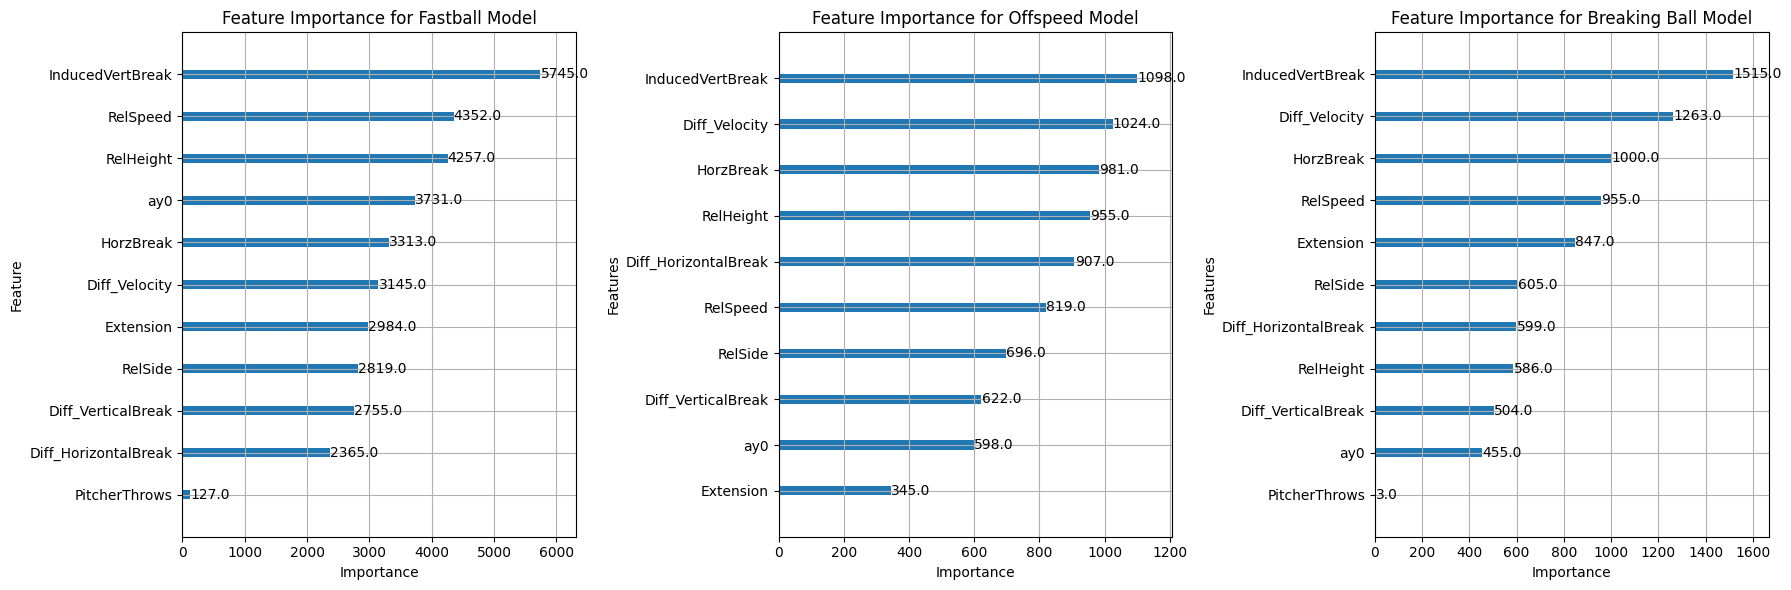

In [84]:
models = [best_model_fb, best_model_os, best_model_bb]
model_names = ['Fastball Model', 'Offspeed Model', 'Breaking Ball Model']  # Names for the models for labeling purposes
X_trains = [X_train_fb, X_train_os, X_train_bb]

# Setup the matplotlib figure and axes for 3 columns and 1 row
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # Adjust overall figure size as needed

for model, name, X_train, ax in zip(models, model_names, X_trains, axes.flatten()):
    # Convert feature names to list of strings
    feature_names = X_train.columns.tolist()
    
    # Plotting on the specified subplot axis
    xgb.plot_importance(model, ax=ax, importance_type='weight', title=f'Feature Importance for {name}', xlabel='Importance')
    
# Set the y-axis label only for the first subplot to avoid clutter
axes[0].set_ylabel('Feature')

plt.tight_layout()  
plt.show()

## Test Model

In [86]:
models = [best_model_fb, best_model_os, best_model_bb]
X_tests = [X_test_fb, X_test_os, X_test_bb]
prob_df_list = []

for model, X_test in zip(models, X_tests):
    y_pred_prob = model.predict_proba(X_test)
    
    num_classes = y_pred_prob.shape[1]
    prob_columns = [f'prob_class_{i}' for i in range(num_classes)]
    prob_df = pd.DataFrame(y_pred_prob, columns=prob_columns)
    
    X_test = X_test.reset_index(drop=True)
    prob_df = prob_df.reset_index(drop=True)
    
    X_test_with_probs = pd.concat([X_test, prob_df], axis=1)
    
    prob_df_list.append(X_test_with_probs)
    
X_test_fb_with_probs = prob_df_list[0]
X_test_os_with_probs = prob_df_list[1]
X_test_bb_with_probs = prob_df_list[2]

In [90]:
dfs = [X_test_fb_with_probs, X_test_os_with_probs, X_test_bb_with_probs]

for df in dfs:
    df['bal_val'] = df['prob_class_0'] * 0.063688329
    df['do_val'] = df['prob_class_1'] * 0.766083123
    df['error_val'] = df['prob_class_2'] * -0.236889646
    df['fc_val'] = df['prob_class_3'] * -0.195568767
    df['fb_val'] = df['prob_class_4'] * -0.038050274
    df['hbp_val'] = df['prob_class_5'] * 0.063688329
    df['hmr_val'] = df['prob_class_6'] * 1.374328827
    df['out_val'] = df['prob_class_7'] * -0.195568767
    df['sacb_val'] = df['prob_class_8'] * -0.10808108
    df['sacf_val'] = df['prob_class_9'] * -0.236889646
    df['single_val'] = df['prob_class_10'] * 0.467292971
    df['sc_val'] = df['prob_class_11'] * -0.065092516
    df['sw_val'] = df['prob_class_12'] * -0.118124936
    df['triple_val'] = df['prob_class_13'] * 1.05755625
    
    df['rv_val'] = df[['bal_val', 'do_val', 'error_val', 'fc_val', 'fb_val', 'hbp_val', 'hmr_val', 'out_val', 'sacb_val', 'sacf_val', 'single_val', 'sc_val', 'sw_val', 'triple_val']].sum(axis=1)

    
combined_df = pd.concat([X_test_fb_with_probs, X_test_os_with_probs, X_test_bb_with_probs])

<Axes: xlabel='xRV', ylabel='Count'>

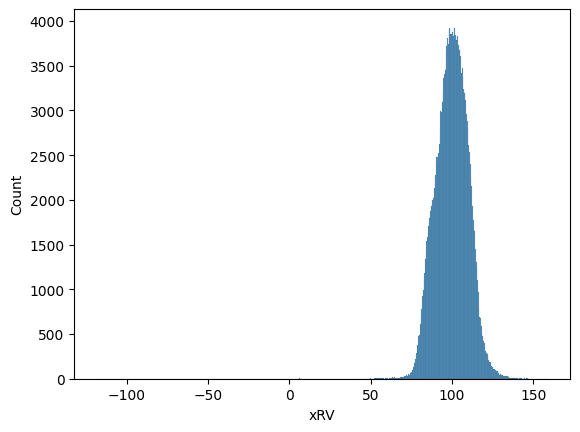

In [97]:
combined_df['xRV'] = 100 - ((combined_df['rv_val'] - combined_df['rv_val'].mean()) / combined_df['rv_val'].std()) * 10

combined_df[['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'xRV']]


sns.histplot(data = combined_df,
            x = 'xRV')

## Save Models

In [36]:
import pickle

with open('best_model_fb.pkl', 'wb') as file:
    pickle.dump(model, file)
    

with open('best_model_os.pkl', 'wb') as file:
    pickle.dump(model, file)
    

with open('best_model_bb.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# FB Model
    df_fb = data[data['pitch_type'].isin(fastball)]
    y_pred_prob_fb = fb_model.predict_proba(df_fb[features])
    prob_df_fb = pd.DataFrame(y_pred_prob_fb, columns=label_encoder.inverse_transform(range(len(label_encoder.classes_))))
    prob_df_fb = prob_df_fb[rv_dict.keys()]
    rv_values = pd.Series(rv_dict)
    prob_df_fb['rv_val'] = prob_df_fb.mul(rv_values).sum(axis=1)

    # OS Model
    df_os = data[data['pitch_type'].isin(offspeed)]
    y_pred_prob_os = os_model.predict_proba(df_os[features])
    prob_df_os = pd.DataFrame(y_pred_prob_os, columns=label_encoder.inverse_transform(range(len(label_encoder.classes_))))
    prob_df_os = prob_df_os[rv_dict.keys()]
    df_os['xRV'] = prob_df_os.mul(rv_values).sum(axis=1)
    df_os['Stuff'] = 100 - ((df_os['xRV'] - df_os['xRV'].mean()) / df_os['xRV'].std()) * 10

    # BB Model
    df_bb = data[data['pitch_type'].isin(breaking)]
    y_pred_prob_bb = bb_model.predict_proba(df_bb[features])
    prob_df_bb = pd.DataFrame(y_pred_prob_bb, columns=label_encoder.inverse_transform(range(len(label_encoder.classes_))))
    prob_df_bb = prob_df_bb[rv_dict.keys()]
    df_bb['xRV'] = prob_df_bb.mul(rv_values).sum(axis=1)
    df_bb['Stuff'] = 100 - ((df_bb['xRV'] - df_bb['xRV'].mean()) / df_bb['xRV'].std()) * 10